# SIMULACIÓ DE QUANTUM ANNEALING
Robert Vila Alsina,

Primavera 2023

Pràctiques d'empresa, tutors: Bruno Julià i Carles Calero

## Quantum Annealing

Aquesta forma de computació quàntica utilitza el Teorema Adiabàtic per a evolucionar el Hamiltonià d'un conjunt de qubits en el temps fins a trobar l'estat de mínima energia. Al principi, s'aplica un camp molt fort en la direcció transversal x que força els spins cap a una direcció. El camp transversal es va reduint de forma adiabàtica i al final obtenim el ground state. 

L'Hamiltonià del sistema es pot expressar:

$$ \mathcal{H}(t)=\mathcal{H}_0-\Gamma(t) \sum_i \sigma_i^x $$
on:
$$ \mathcal{H}_0=-\sum_{i,j} J_{i j} \sigma_i^z \sigma_j^z-\alpha \sum_i \sigma_i^z$$

La idea és començar amb una $\Gamma (t)$ molt gran i anar-la reduïnt poc a poc, de manera adabàtica. Això correspon al camp transversal x que apliquem als qubits. Després de l'evolució, l'únic terme que quedarà serà el $\mathcal{H}_0$, que ens permetrà trobar quina és l'energia associada al groundstate.

La importància d'aquesta tècnica de computació quàntica és que es pot fer servir com a eina per a resoldre problemes d'optimització de combinatòria. Això es pot fer expressant el problema com un Hamiltonià d'un model d'Ising i trobant un anàleg en el conjunt de qubits i les seves connexions. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np


### Nombre d'spins
Elegim el nombre d'spins del sistema N que volem simular

In [2]:
N = 4

### Possibles estats
El nombre d'estats del sistema creix com $2^N$ on N és el nombre de bits del sistema. Això fa que per un nombre mitjanament gran de spins no sigui possible computar tots els estats per a trobar el de mínima energia.


[[-1. -1. -1. -1.]
 [-1. -1. -1.  1.]
 [-1. -1.  1. -1.]
 [-1. -1.  1.  1.]
 [-1.  1. -1. -1.]
 [-1.  1. -1.  1.]
 [-1.  1.  1. -1.]
 [-1.  1.  1.  1.]
 [ 1. -1. -1. -1.]
 [ 1. -1. -1.  1.]
 [ 1. -1.  1. -1.]
 [ 1. -1.  1.  1.]
 [ 1.  1. -1. -1.]
 [ 1.  1. -1.  1.]
 [ 1.  1.  1. -1.]
 [ 1.  1.  1.  1.]]
Tindrem un total de: 16 estats


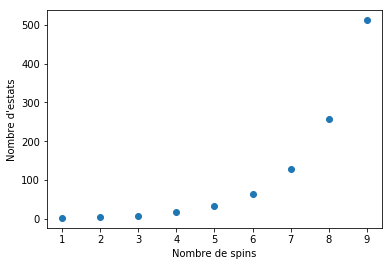

In [3]:
#Fem una matriu amb tots els possibles estats dels spins (2^N)
#En una matriu de N columnes i 2^N files

def matriu_estats(N):
    matriu = np.zeros((2**N,N))
    for i in range(2**N):
        for j in range(N):
            matriu[i,j] = (i // 2**(N-j-1)) % 2
    matriu[matriu == 0] = -1
    return matriu

estats_spins = matriu_estats(N)
print(estats_spins)

print("Tindrem un total de:", len(estats_spins), "estats")

#Grafiquem el nombre d'estats en funció del nombre de spins
x = np.arange(1,10)
y = 2**x
plt.plot(x,y, "o")
plt.xlabel("Nombre de spins")
plt.ylabel("Nombre d'estats")
plt.show()

### Termes d'interacció entre els spins
Per altra banda, la matriu $J_{ij}$ és el patró de interaccions entre els spins. Així, $J_{13}$ mesurarà les interaccions de l'spin 1 amb el 3. Una possible aproximació podria ser considerar que cada spin només interactua amb els dels seu voltant, els primers veïns, de forma que només quedarien diferents de zero la diagonal per sobre de la diagonal principal i la seva simètrica.

En el nostre cas, com que només ens interessa veure com se simula el procés, aleatoritzarem els valors de la matriu. Això ho farem agafant valors d'una distribució Gaussiana de mitjana 0 i desviació estàndard 1.

In [4]:
#Declarem la matriu J d'interacció entre diferents spins
matrix_J = np.random.normal(loc=0, scale=1, size=(N, N))
matrix_J[np.diag_indices(N)] = 0


matrix_J

array([[ 0.        , -1.2634578 ,  1.83827646, -0.40129363],
       [-0.89672287,  0.        , -0.13528561,  1.15612491],
       [ 0.71199717, -0.60222297,  0.        , -0.48045438],
       [-0.0265928 ,  1.62816494, -1.35694291,  0.        ]])

### Terme d'interacció amb si mateix

També existeix un terme energètic associat al propi spin, $\alpha$. Per exemple, podem posar $\alpha = 1$

In [5]:
#Declarem el terme d'interacció amb si mateix, alpha
alpha = 1
alpha

1

### Hamiltonià inicial del sistema

Amb el nombre d'spins amb el que treballem, podem trobar quin és el ground state abans de simular l'evolució temporal del sistema. Això ho podem fer amb els valors propis. 

El Hamiltonià final del sistema:

$$ \mathcal{H}_0=-\sum_{i,j} J_{i j} \sigma_i^z \sigma_j^z-\alpha \sum_i \sigma_i^z$$

On $\sigma_i^z$ és la matriu de Pauli en la direcció z que actua en l'spin i. És important notar que els termes del sumatori tenen productes tensorials per una identitat 2x2 implícits en totes les posicions que no estem aplicant la matriu de Pauli. Per exemple, el terme d'interacció entre els spins 2 i 3 d'un sistema de 5 bits serà:

$$J_{23}( I \otimes \sigma^z \otimes \sigma^z \otimes I \otimes I )$$

Matrius
$$ I = \begin{pmatrix}
1 & 0\\
0 & 1
\end{pmatrix}\hspace{2cm}
\sigma^z = \begin{pmatrix}
0 & 1\\
1 & 0
\end{pmatrix} \hspace{2cm}
\sigma^x = \begin{pmatrix}
1 & 0 \\
0 & -1
\end{pmatrix}

$$

Energies del ground state:  [-5.2748928  -5.2748928  -4.71390995 -3.19914695 -2.36685989 -2.16515615
 -0.26883701  0.80085305  1.63314011  1.78706844  1.78706844  1.83484385
  3.28609005  3.73116299  4.20173431  4.20173431]
Vectors propis del ground state:  [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.

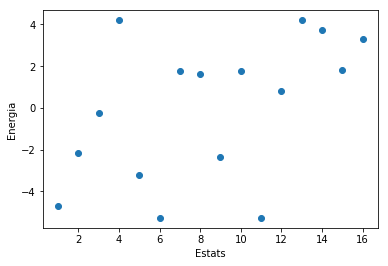

Energia mínima:  -5.274892802424301 Corresponent a l'estat:  6 que és:  [-1.  1. -1.  1.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [6]:
#Declarem les matrius de Pauli i la identitat
sigma_x = np.array([[0,1],[1,0]])
sigma_z = np.array([[1,0],[0,-1]])
identitat = np.identity(2)

#Calculem les energies del ground state, H0

#Operador Hamiltonià H0
def Ham0():
    H = np.zeros((2**N, 2**N))

    #Afegim el terme alpha
    for i in range(N):
        malpha = np.identity(1)
        for j in range(N):
            if j == i:
                malpha = np.kron(malpha, sigma_z)
            else:
                malpha = np.kron(malpha, identitat)
        H -= alpha*malpha

    #Afegim el terme J
    for i in range(N-1):
        for j in range(i,N):
            mJ = np.identity(1)
            for k in range(N):
                if k == i:
                    mJ = np.kron(mJ, sigma_z)
                elif k == j:
                    mJ = np.kron(mJ, sigma_z)
                else:
                    mJ = np.kron(mJ, identitat)
            H -= matrix_J[i,j]*mJ
    return H

H0 = Ham0()

#Calculem les energies del ground state, H0
vals_H0, vecs_H0 = np.linalg.eigh(H0)

print ("Energies del ground state: ", vals_H0)
print ("Vectors propis del ground state: ", vecs_H0)
#Trobem un anàleg de l'ordre de les energies amb els estats corresponents
ordre = []
for i in range(2**N):
    num = np.where(vecs_H0[:,i] == 1)[0][0]
    ordre.append(num)


#Grafiquem l'energia H0 per tots els estats possibles
#En un eix el nombre d'estat i en l'altre l'energia
ordremes1 = [i+1 for i in ordre]
plt.plot(ordremes1, vals_H0, "o")
plt.xlabel('Estats')
plt.ylabel('Energia')
plt.show()

print("Energia mínima: ", vals_H0[0], "Corresponent a l'estat: ", ordremes1[0], "que és: ", estats_spins[ordre[0]])

E_min = vals_H0[0]

#Guardem el vector propi corresponent a l'estat amb energia mínima
vec_minH0 = vecs_H0[:,0]
print (vec_minH0)


### Operador Hamiltonià temporal

Com s'ha anunciat al principi, l'operador hamiltonià de la nostra simulació també tindrà un terme que evolucionarà amb el temps. Serà de la forma:

$$ \mathcal{H}(t)=\mathcal{H}_0-\Gamma(t) \sum_i \sigma_i^x $$
on:
$$ \mathcal{H}_0=-\sum_{i,j} J_{i j} \sigma_i^z \sigma_j^z-\alpha \sum_i \sigma_i^z$$

És molt importnant escollir una funció $\Gamma (t)$ que avanci de forma prou lenta com perquè el sistema no salti entre el ground state i els primers excitats. El sistema ha d'evolucionar de forma adiabàtica. Per exemple, nosaltres farem servir:

$$ \Gamma (t) = \frac{10}{1+t}$$


In [7]:


#Operador Hamiltonià
def H(t):
    H = np.zeros((2**N, 2**N))

    #Afegim el terme alpha
    for i in range(N):
        malpha = np.identity(1)
        for j in range(N):
            if j == i:
                malpha = np.kron(malpha, sigma_z)
            else:
                malpha = np.kron(malpha, identitat)
        H -= alpha*malpha

    #Afegim el terme J
    for i in range(N-1):
        for j in range(i,N):
            mJ = np.identity(1)
            for k in range(N):
                if k == i:
                    mJ = np.kron(mJ, sigma_z)
                elif k == j:
                    mJ = np.kron(mJ, sigma_z)
                else:
                    mJ = np.kron(mJ, identitat)
            H -= matrix_J[i,j]*mJ

    #Afegim el terme gamma
    gamma = 10./(t+1.)
    for i in range(N):
        mgamma = np.identity(1)
        for j in range(N):
            if j == i:
                mgamma = np.kron(mgamma, sigma_x)
            else:
                mgamma = np.kron(mgamma, identitat)
        H -= gamma*mgamma

    return H

H0 = H(0)

#Diagonalitzem H0 per obtenir els valors propis i els vectors propis
valors_propis, vectors_propis = np.linalg.eigh(H0)

print("Energies:", valors_propis)


#Guardem l'estat propi del ground state al temps inicial
ground_state = vectors_propis[:,0]

print("Estat inicial:", ground_state)


Energies: [-40.37647869 -22.96478139 -20.5161325  -19.32492645 -17.94636619
  -3.64659789  -0.90556519  -0.25744468   0.42759959   1.17197223
   3.23606185  17.56985608  19.75184889  20.98141956  22.44650437
  40.35303041]
Estat inicial: [0.30575786 0.27367019 0.26011643 0.22145446 0.28158529 0.28325994
 0.23474835 0.22461444 0.27503917 0.23525774 0.28130498 0.22880335
 0.22309283 0.21441737 0.22346614 0.20413396]


### Evolució temporal

Per a veure com avança el Hamiltonià amb el temps, haurem de simular l'Equació d'Schrödinger depenent del temps (ESDT). Això ho farem mitjançant el mètode de Crank-Nicolson, un mètode numèric de diferències finites per a resoldre equacions en derivades parcials.

\begin{equation}
i \frac{\partial|\phi(t)\rangle}{\partial t}=\mathcal{H}(t)|\phi(t)\rangle
\end{equation}

 Primer de tot buscarem una aproximació de l'estat $|\phi(t+\Delta t / 2)\rangle$ una com a semipas endavant des de $t$.
\begin{equation}
 \frac{\partial|\phi(t)\rangle}{\partial t} \approx 2i\frac{\phi \left( t + \Delta t/2\right) - \phi(t)}{\Delta t } 
 \hspace{0.5cm} \xrightarrow{ESDT} \hspace{0.5cm}
 \left|\phi\left(t+\frac{\Delta t}{2}\right)\right\rangle=\left(1-\frac{i \Delta t}{2} \mathcal{H}\right)|\phi(t)\rangle
\end{equation}

Farem el mateix però com un semipas enrere des de $t + \Delta t$.

\begin{equation}
\left|\phi\left(t+\frac{\Delta t}{2}\right)\right\rangle=\left(1+\frac{i \Delta t}{2} \mathcal{H}\right)|\phi(t+\Delta t)\rangle
\end{equation}

Igualem les dues expressions i obtenim:

\begin{equation}
\left(1+i \frac{\Delta t}{2 \hbar} \hat{H}\right) \phi(t+\Delta t)=\left(1-i \frac{\Delta t}{2 \hbar} \hat{H}\right) \phi(t)
\end{equation}

\begin{equation}
|\phi(t+\Delta t)\rangle=\left(1+i \frac{\Delta t}{2} \mathcal{H}\right)^{-1}\left(1-i \frac{\Delta t}{2} \mathcal{H}\right)|\phi(t)\rangle
\end{equation}

Per tant, el problema a resoldre serà:

\begin{equation}
\hat{A} \vec{\Psi}(x, t+\Delta t)=\vec{b}
\end{equation}

On tots els $\mathcal{H} = \mathcal{H}(t)$. Considerarem $\Gamma_1=10 /(t+1)$. \\

El nostre estat inicial serà l'estat de mínima energia de l'Hamiltonià depenent del temps a l'instant inicial


[-40.37647869308939, -36.7747452812953, -33.77823410317737, -31.249538046960478, -29.08707804359509, -27.2195880991143, -25.59314944952767, -24.164359608732763, -22.898410257885924, -21.767736051141966, -20.751811792251218, -19.83521163768726, -19.00481518091015, -18.249194573320146, -17.55915415849928, -16.927529358297697, -16.34830064584163, -15.815659775067184, -15.323683283379815, -14.866983257964888, -14.441558410959175, -14.044727873973025, -13.674310331276, -13.328089870130015, -13.003903368211844, -12.699828114268833, -12.414143336320572, -12.145274605258894, -11.891881336258944, -11.65290285851679, -11.42739997234114, -11.214340334434036, -11.01257000922139, -10.820983034728693, -10.638691120012096, -10.465049135493462, -10.29957534615962, -10.141874484461166, -9.991595645395375, -9.848386784307923, -9.711834838948349, -9.581440592721124, -9.456671644528658, -9.33706564274698, -9.222303949035908, -9.112201076439616, -9.006627192454228, -8.905426700078197, -8.808381629822668, -

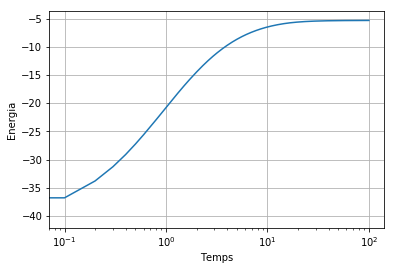

Energia final: -5.2848465688600115
Valor teòric: -5.274892802424301


In [8]:
#Crank-Nicolson per a la resolució de l'equació de Schrödinger en el temps

psi = ground_state
psi = psi/np.linalg.norm(psi) #Normalitzem

#Definim el temps inicial i final
t_inicial = 0
t_final = 100
dt = 0.1

#Definim el temps
temps = np.arange(t_inicial, t_final, dt)
vect_energy = []


productes_escalars = []

for t in temps:
    #Definim les matrius de propagació
    U_mes = np.identity(2**N) + 1j*dt/2.*H(t)
    U_menys = np.identity(2**N) - 1j*dt/2.*H(t)

    #Fem un pas de temps dt
    psi = np.linalg.solve(U_mes, np.dot(U_menys, psi))

    #Calculem l'energia
    energia = np.real(np.dot(np.conjugate(psi), np.dot(H(t), psi)))
    vect_energy.append(energia)

    #Calculem el producte escalar entre psi i el vector propi del ground state
    producte_escalar = np.linalg.norm((np.dot(np.conjugate(psi), vec_minH0)))**2
    productes_escalars.append(producte_escalar)

print(vect_energy)

#Grafiquem l'energia en funció del temps amb l'eix x en escala logarítmica
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xscale('log')
plt.plot(temps, vect_energy)
plt.yticks(np.arange(-40,0,5))
plt.xlabel('Temps')
plt.ylabel('Energia')
plt.grid()
plt.ylim = (-40,0)
plt.show()

#Mostrem el valor final de l'energia
print("Energia final:", vect_energy[-1])
print("Valor teòric:", E_min)

Veiem que l'energia avança cap al ground-state. 

Una altra forma de comprovar si estem realitzant un procés adiabàtic és amb el producte escalar entre el vector propi del groundstate i el nostre vector. Idelment hauria d'avançar cap a 1.

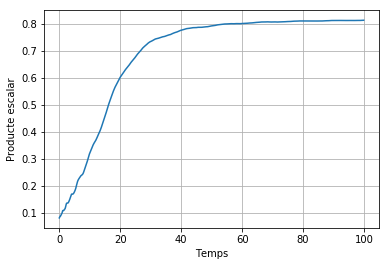

In [9]:
#Grafiquem els productes escalars en funció del temps
plt.plot(temps, productes_escalars)
plt.xlabel('Temps')
plt.ylabel('Producte escalar')
plt.grid()
plt.show()


## REFERÈNCIES

Quantum Annealing in the transverse Ising Model, Óscar Promio MuÑnoz